# Project 

In [64]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Data Description...**

In [65]:
food_inspections = pd.read_csv('data/food-inspections.csv', sep=',')

**Drop the columns we don't need**

We don't need the location since we already have the latitude and longitude columns. 
The Zip codes are not required either.

In [66]:
food_inspections = food_inspections.drop(['Zip', 'Zip Codes','Historical Wards 2003-2015', 'Community Areas', 'Census Tracts','Wards'], axis=1)

In [67]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,CHICAGO,IL,2019-11-08T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':..."
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,CHICAGO,IL,2019-11-08T00:00:00.000,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'..."
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,CHICAGO,IL,2019-11-08T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'..."
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,CHICAGO,IL,2019-11-08T00:00:00.000,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':..."
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,CHICAGO,IL,2019-11-08T00:00:00.000,Complaint,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':..."


In [68]:
food_inspections['DBA Name'].isnull().values.any()

False

**Check the cities**

We see that chicago is there several times. 

In [69]:
food_inspections.groupby('City')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

City
CHICAGO               194955
Chicago                  322
chicago                   97
CCHICAGO                  46
SCHAUMBURG                25
MAYWOOD                   15
ELK GROVE VILLAGE         13
CHicago                   12
CHESTNUT STREET           11
EVANSTON                  11
CICERO                     9
INACTIVE                   8
SKOKIE                     8
CHICAGOCHICAGO             7
NILES NILES                7
CHCHICAGO                  6
ELMHURST                   6
CALUMET CITY               6
OAK PARK                   5
WORTH                      5
SUMMIT                     4
CHARLES A HAYES            4
SCHILLER PARK              3
BRIDGEVIEW                 3
ROSEMONT                   3
CHCICAGO                   3
CHICAGOI                   3
ALSIP                      3
EAST HAZEL CREST           3
PLAINFIELD                 3
                       ...  
EVERGREEN PARK             1
TINLEY PARK                1
PALOS PARK                 1
BURNHAM  

In [70]:
def city_clear(city):
    city = str(city).lower()
    # YT : plusieurs déformations de chicago étaient présents -> du coup j'en ai fait une liste 
    chicagos = ['cchicago', 'chcicago', 'chicagochicago', 'chchicago', 'chicago.', 'chicagoi', 'chicagohicago', '312chicago']
    if city in chicagos:
        city = 'chicago'
    return city  

food_inspections.City = food_inspections.City.apply(city_clear)

In [71]:
food_inspections.groupby('City')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

City
chicago                 195457
nan                        138
schaumburg                  25
maywood                     16
elk grove village           13
evanston                    11
chestnut street             11
cicero                       9
inactive                     8
skokie                       8
niles niles                  7
calumet city                 6
elmhurst                     6
oak park                     5
worth                        5
summit                       4
charles a hayes              4
alsip                        4
east hazel crest             3
rosemont                     3
schiller park                3
plainfield                   3
bridgeview                   3
naperville                   2
streamwood                   2
blue island                  2
berwyn                       2
chicago heights              2
bedford park                 2
bannockburndeerfield         2
highland park                2
des plaines                  1
bol

**Deleting other cities than Chicago**

We keep only chicago. Most data is overthere and the rest is not required. We check the state as well (different Chicago ?). At the end, we are sure to work only with restaurants in Chicago, Illinois.

In [72]:
food_inspections = food_inspections[food_inspections.City == 'chicago']

In [73]:
food_inspections.groupby('City')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

City
chicago    195457
Name: DBA Name, dtype: int64

In [74]:
food_inspections.groupby('State')['DBA Name']\
    .count()\
    .sort_values(ascending=False)

State
IL    195434
Name: DBA Name, dtype: int64

In [75]:
food_inspections = food_inspections.drop(['City','State'], axis=1)

In [76]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,2019-11-08T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':..."
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,2019-11-08T00:00:00.000,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'..."
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,2019-11-08T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'..."
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,2019-11-08T00:00:00.000,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':..."
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,2019-11-08T00:00:00.000,Complaint,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':..."


**Checking the license numbers of restaurants**

We check if don't have duplicates. Some places were inspected several times and have thus multiple rows in the dataset. We want to count the number of inspections done on each establishment so we will transform the data set to make 'Establishment'-centric.

In [77]:
license_count = food_inspections.groupby("License #")\
    .count()\
    .sort_values(by='DBA Name', ascending=False).copy()

In [78]:
license_count['Inspection ID'].head()

License #
0.0          505
1354323.0    192
14616.0      176
1574001.0     83
1974745.0     59
Name: Inspection ID, dtype: int64

In [79]:
food_inspections.groupby("License #")['Inspection Date']\
    .count()\
    .sort_values(ascending=False)

License #
0.0          505
1354323.0    192
14616.0      176
1574001.0     83
1974745.0     59
1142451.0     49
1884255.0     48
2083833.0     46
1490035.0     46
1596210.0     45
20481.0       44
60184.0       44
1476553.0     42
1000572.0     41
1302136.0     40
2013962.0     39
1094.0        39
18234.0       39
29151.0       38
55054.0       38
2108657.0     38
1042888.0     37
9154.0        37
1879470.0     36
4190.0        36
22811.0       36
25152.0       36
1909713.0     35
80690.0       35
75883.0       35
            ... 
1380171.0      1
1380167.0      1
1380135.0      1
1380095.0      1
1380089.0      1
1380041.0      1
2068777.0      1
1380507.0      1
1380574.0      1
2065300.0      1
1381013.0      1
1381325.0      1
2065427.0      1
1381272.0      1
1381261.0      1
2065470.0      1
1381062.0      1
1381057.0      1
2492840.0      1
2588968.0      1
1380578.0      1
1380985.0      1
1380929.0      1
1380788.0      1
1380782.0      1
1380781.0      1
1380748.0      1
1380

Problème à résoudre: license # = 0.0 et peut-être 1.0 non catégorisée. 

In [80]:
food_inspections[food_inspections['License #']==1]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
188374,250567,HARVEST CRUSADES MINISTRIES,HARVEST CRUSADES MINISTRIES,1.0,Special Event,Risk 2 (Medium),118 N CENTRAL AVE,2010-06-04T00:00:00.000,Special Events (Festivals),Pass,NaN,41.882845,-87.765095,"{'longitude': '41.88284507471884', 'latitude':..."


We will considerate a license number of '0' equivalent to a missing value

In [81]:
food_inspections.replace(0, np.nan, inplace=True)
food_inspections['License #'].value_counts()

1354323.0    192
14616.0      176
1574001.0     83
1974745.0     59
1142451.0     49
1884255.0     48
1490035.0     46
2083833.0     46
1596210.0     45
20481.0       44
60184.0       44
1476553.0     42
1000572.0     41
1302136.0     40
2013962.0     39
18234.0       39
1094.0        39
29151.0       38
55054.0       38
2108657.0     38
1042888.0     37
9154.0        37
1879470.0     36
22811.0       36
25152.0       36
4190.0        36
1273271.0     35
80690.0       35
1909713.0     35
75883.0       35
            ... 
1195287.0      1
1943151.0      1
1942557.0      1
1942527.0      1
1195541.0      1
1942495.0      1
2391518.0      1
2391460.0      1
2202689.0      1
2391428.0      1
22143.0        1
692.0          1
2391388.0      1
2652289.0      1
2652293.0      1
1968886.0      1
2391311.0      1
2391300.0      1
2523715.0      1
1195640.0      1
2652317.0      1
2391260.0      1
15174.0        1
1942344.0      1
1942355.0      1
1942374.0      1
1942376.0      1
2391407.0     

We see now that the 0's are removed

**New Year format ?**

In [82]:
food_inspections['year'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[0])
food_inspections['month'] = food_inspections['Inspection Date'].apply(lambda x: x.split('-')[1])
food_inspections['Inspection Date'] = food_inspections['month'] + '/' + food_inspections['year']
food_inspections = food_inspections.drop(['year','month'], axis=1)

In [83]:
food_inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,11/2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':..."
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'..."
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,11/2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'..."
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':..."
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,11/2019,Complaint,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':..."


In [84]:
food_inspections['test'] = food_inspections['Inspection ID'].astype(str) + food_inspections['License #'].astype(str) + food_inspections['Inspection Date'].astype(str)
food_inspections.test.is_unique

False

In [85]:
print('Number of rows in dataset before deleting the duplicates: {}'.format(food_inspections.shape))
food_inspections = food_inspections.drop_duplicates(subset=['test'], keep=False)
print('Number of rows in dataset after deleting the duplicates: {}'.format(food_inspections.shape))

Number of rows in dataset before deleting the duplicates: (195457, 15)
Number of rows in dataset after deleting the duplicates: (194975, 15)


In [86]:
food_inspections = food_inspections.drop(['test'], axis=1)

**Nan values: Violations**

In [87]:
food_inspections[food_inspections.Violations.isnull()].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'..."
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':..."
6,2345356,JUST A PIZZA PLUS INC,JUST A PIZZA PLUS,75583.0,Restaurant,Risk 1 (High),5136 S ARCHER AVE,11/2019,Complaint Re-Inspection,Pass,NaN,41.800619,-87.731143,"{'longitude': '41.8006193315046', 'latitude': ..."
10,2345374,BAR MARTA,HERITAGE,2263375.0,Restaurant,Risk 1 (High),2700 W CHICAGO AVE,11/2019,Canvass,No Entry,NaN,41.895778,-87.694300,"{'longitude': '41.89577762053548', 'latitude':..."
17,2345365,CARNICERIA Y FRUTERIA 'LOS ALTOS' INC.,CARNICERIA Y FRUTERIA LOS ALTOS,1802424.0,Grocery Store,Risk 1 (High),2959 W 40TH ST,11/2019,Complaint Re-Inspection,Pass,NaN,41.820772,-87.699407,"{'longitude': '41.8207715298359', 'latitude': ..."


In [88]:
food_inspections.head(60)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,11/2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':..."
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'..."
2,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,11/2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'..."
3,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':..."
4,2345376,GARIBAY POULTRY,GARIBAY POULTRY,1908500.0,CUSTOM POULTRY SLAUGHTER,Risk 2 (Medium),2100 S CALIFORNIA AVE,11/2019,Complaint,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.853688,-87.695652,"{'longitude': '41.85368770723974', 'latitude':..."
5,2345345,CARNITAS URUAPAN,CARNITAS URUAPAN,2298331.0,Restaurant,Risk 1 (High),1725 W 18TH ST,11/2019,Complaint,Pass,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.857632,-87.669775,"{'longitude': '41.85763234806772', 'latitude':..."
6,2345356,JUST A PIZZA PLUS INC,JUST A PIZZA PLUS,75583.0,Restaurant,Risk 1 (High),5136 S ARCHER AVE,11/2019,Complaint Re-Inspection,Pass,NaN,41.800619,-87.731143,"{'longitude': '41.8006193315046', 'latitude': ..."
7,2345360,IDOF Fresh Mediterranean,IDOF Fresh Mediterranean,2688786.0,Restaurant,Risk 1 (High),6558 N SHERIDAN RD,11/2019,License Re-Inspection,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,42.001799,-87.660901,"{'longitude': '42.0017987908865', 'latitude': ..."
8,2345329,Subway,Subway,2079385.0,Restaurant,Risk 1 (High),1406 W 18th ST,11/2019,Complaint,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.857981,-87.661610,"{'longitude': '41.85798053852561', 'latitude':..."
9,2345319,GOPUFF,GOPUFF,2684558.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'..."


In [89]:
food_inspections_no_violations = food_inspections.copy()
print(food_inspections_no_violations.shape)
food_inspections_no_violations = food_inspections_no_violations[food_inspections_no_violations['Violations'].notna()]
#pourquoi pas: food_inspections_no_violations = food_inspections[food_inspections['Violations'].notna()].copy()
#copie directement que la slice qui nous intéresse
# +1 : YT : Je suis d'accord aussi

(194975, 14)


In [90]:
food_inspections_no_violations.shape

(143352, 14)

In [91]:
viola_count = food_inspections_no_violations.groupby("License #")['Violations']\
    .count()
viola_count = pd.DataFrame(viola_count)
viola_count

,Violations
License #,
2.0,14
9.0,14
40.0,17
62.0,16
85.0,3
99.0,11
115.0,7
126.0,1
139.0,2


In [92]:
food_inspections = food_inspections.merge(viola_count, on="License #", how='outer')\
    .rename(columns={'Violations_x':'Violations','Violations_y':'Violation Count'})

In [93]:
food_inspections.shape

(194975, 15)

In [94]:
food_inspections[food_inspections.Violations.isnull()].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation Count
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",NaN
2,2320260,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,10/2019,License,Fail,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",NaN
4,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0
5,2320873,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,10/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0
9,1454314,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2015,License,Pass,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0


In [95]:
food_inspections['Violation Count'].fillna(0, inplace=True)

In [96]:
food_inspections[food_inspections.Violations.isnull()].head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Violation Count
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",0.0
2,2320260,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,10/2019,License,Fail,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",0.0
4,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0
5,2320873,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,10/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0
9,1454314,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2015,License,Pass,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0


**Nan values: Latitude / Longitude**

Remove if we don't know the location

In [97]:
#print("Rows having unknown latitude: {}".format(food_inspections[food_inspections.Latitude.isnull()].shape)
food_inspections.dropna(subset=['Latitude'], inplace=True)
print(food_inspections[food_inspections.Longitude.isnull()].shape)
print(food_inspections[food_inspections.Location.isnull()].shape)

(0, 15)
(0, 15)


Same rows having unknown latitude and longitude. No additional information in the location column.

**Violations-centered dataset**

In [98]:
#Here we change the violations column for a simple violation ID for easier use later on
vio = food_inspections.copy()
vio['Violations'] = vio['Violations'].str.split(pat = '.', n=1, expand = True)[0]
vio = vio.rename(columns={"Violations": "Violation ID"})
vio.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violation ID,Latitude,Longitude,Location,Violation Count
0,2345323,ARMAND'S PIZZERIA,ARMAND'S PIZZERIA,2698587.0,Restaurant,Risk 1 (High),29 N WACKER DR,11/2019,License,Pass w/ Conditions,3,41.882700,-87.636638,"{'longitude': '41.88270035458986', 'latitude':...",1.0
1,2345321,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,11/2019,License Re-Inspection,Pass,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",0.0
2,2320260,GOPUFF,GOPUFF,2684560.0,Grocery Store,Risk 3 (Low),1801 W WARNER AVE,10/2019,License,Fail,NaN,41.956846,-87.674395,"{'longitude': '41.956845683288854', 'latitude'...",0.0
3,2345325,TACO MAX MEXICAN GRILL,TACO MAX MEXICAN GRILL,2699082.0,Restaurant,Risk 1 (High),3402 W MONTROSE AVE,11/2019,License,Pass w/ Conditions,3,41.961238,-87.713284,"{'longitude': '41.961237630038035', 'latitude'...",1.0
4,2345370,CAFE BALLOU,CAFE BALLOU & DELI,2433048.0,Restaurant,Risk 1 (High),939 N WESTERN AVE,11/2019,Canvass,No Entry,NaN,41.898706,-87.686773,"{'longitude': '41.89870606533506', 'latitude':...",3.0


Now that we simplified the violations we can have an idea of the number of times each of these were reported

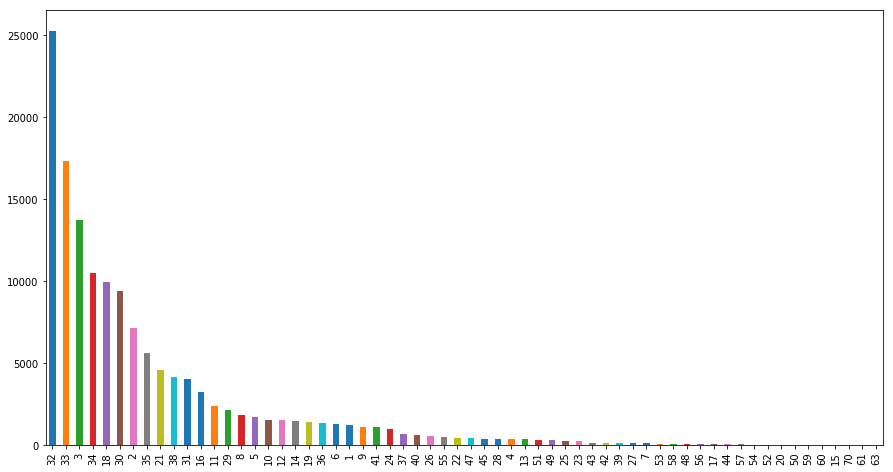

In [99]:
#Here we plot the number of ocurrences of each violations for a quick visualization of the situation
vio["Violation ID"].dropna(inplace=True)
vio["Violation ID"].value_counts().plot.bar(figsize = [15,8])

So what are the main violations we observe ?\
32: FOOD AND NON\
33: FOOD AND NON\
3: MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING\
34: PLANT FOOD PROPERLY COOKED FOR HOT HOLDING\
18: PROPER COOKING TIME & TEMPERATURES\
30: FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED\
2: FACILITIES TO MAINTAIN PROPER TEMPERATURE\
35: APPROVED THAWING METHODS USED\
21: PROPER HOT HOLDING TEMPERATURES\
38: INSECTS, RODENTS, & ANIMALS NOT PRESENT\
31: WATER & ICE FROM APPROVED SOURCE\
16: FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPORTATION

In [100]:
# Violations Lists
violations = food_inspections_no_violations.Violations.str.split("|")
# transform list of list of violations to list of violations
violations = violations.apply(pd.Series).stack().reset_index(drop=True)
# delete comments on each violation type
violations = violations.str.split("-")
violations = violations.map(lambda x: x[0])

In [101]:
violations = violations.str.lstrip()
violations = violations.str.rstrip()
violations = list(set(violations))

In [102]:
violations.sort()

In [104]:
# Je crois que dans le data, il y a un mélange de plusieurs violations par ex) pour le resto et l'hôtel
for v in violations:
    print(v)

1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES
1. SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PROPERLY LABELED, SHELLFISH TAGS IN PLACE
10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE
10. SEWAGE AND WASTE WATER DISPOSAL, NO BACK SIPHONAGE, CROSS  CONNECTION AND/OR BACK FLOW
11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED
11. FOOD OBTAINED FROM APPROVED SOURCE
12. FOOD RECEIVED AT PROPER TEMPERATURE
12. HAND WASHING FACILITIES: WITH SOAP AND SANITARY HAND DRYING DEVICES, CONVENIENT AND ACCESSIBLE TO FOOD PREP AREA
13. FOOD IN GOOD CONDITION, SAFE, & UNADULTERATED
13. NO EVIDENCE OF RODENT OR INSECT INFESTATION, NO BIRDS, TURTLES OR OTHER ANIMALS
14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7
14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TAGS, PARASITE DESTRUCTION
15. FOOD SEPARATED AND PROTECTED
15. UNWRAPPED AND POTENTIALLY HAZARDOUS FOOD NOT RE
16. FOOD
16. FOOD PROTECTED DURING STORAGE, PREPARATION, DISPLAY, SERVICE AND TRANSPO

**Creating working dataset**



In [ ]:
food_inspections_resto = food_inspections.copy()

In [ ]:
count = food_inspections_resto.groupby('License #')['Inspection ID'].count()

food_inspections_resto = pd.merge(food_inspections_resto, count, on='License #')\
    .rename(columns={'Inspection ID_y':'# of Inspections','Inspection ID_x':'Inspection ID'})\
    .drop(['date','Inspection ID','DBA Name','AKA Name','Violations','Results','Inspection Type','Location'], axis=1)

In [ ]:
food_inspections_resto.head()

In [ ]:
print('Number of rows to be deleted: {}'.format(food_inspections_resto[food_inspections_resto.duplicated()].shape))
food_inspections_resto = food_inspections_resto.drop_duplicates()
print('Number of rows in dataset after deletion: {}'.format(food_inspections_resto.shape))

In [ ]:
food_inspections_resto.head()

**Plot Geographical loc of restaurants**

In [ ]:
import os
import pandas as pd
import json

import folium

In [ ]:
folium.__version__ == '0.10.0'

In [ ]:
chicago_coord = [41.85, -87.7]

In [ ]:
m = folium.Map(location=chicago_coord)
m

In [ ]:
latitudes = food_inspections_resto.Latitude
longitudes = food_inspections_resto.Longitude

plt.figure()
plt.scatter(latitudes,longitudes)

In [ ]:
# Need more data cleaning
food_inspections_resto = food_inspections_resto.dropna()

In [ ]:
for index, row in food_inspections_resto.iterrows():
    if index < 1000:
        folium.Marker([row["Latitude"], row["Longitude"]], popup=str(index)).add_to(m)
    else: 
        break

In [ ]:
m

**Map with markers of each type of risk reported**

In [ ]:
#Separation of the dataset depending on the risk level
risk1 = food_inspections[food_inspections["Risk"]=='Risk 1 (High)'].copy()
risk2 = food_inspections[food_inspections["Risk"]=='Risk 2 (Medium)'].copy()
risk3 = food_inspections[food_inspections["Risk"]=='Risk 3 (Low)'].copy()

In [ ]:
risk1.head()

In [ ]:
#new map for the risks
riskmap = folium.Map(location=chicago_coord)
riskmap

In [ ]:
risk1.shape[0]

In [ ]:
#Preparation for use of latitude and longitude for markers
risk1['Latitude'].reset_index(drop=True, inplace=True)
risk1['Latitude'].dropna(inplace=True)
risk1['Longitude'].reset_index(drop=True, inplace=True)
risk1['Longitude'].dropna(inplace=True)

risk2['Latitude'].reset_index(drop=True, inplace=True)
risk2['Latitude'].dropna(inplace=True)
risk2['Longitude'].reset_index(drop=True, inplace=True)
risk2['Longitude'].dropna(inplace=True)

risk3['Latitude'].reset_index(drop=True, inplace=True)
risk3['Latitude'].dropna(inplace=True)
risk3['Longitude'].reset_index(drop=True, inplace=True)
risk3['Longitude'].dropna(inplace=True)

In [ ]:
#plot
for i in range(100):
    risk1_location = [risk1['Latitude'][i], risk1['Longitude'][i]]
    folium.Marker(risk1_location, popup="High Risk", icon=folium.Icon(color ='red', icon = 'map-marker')).add_to(riskmap)

In [ ]:
riskmap